# Preprocessing of Image Data for Convolutional Neural Net

## This approach was adopted from the following guide: [link](https://deeplizard.com/learn/video/LhEMXbjGV_4)

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [59]:
# Organize data into train, valid, test dirs
print(f'Current Working Directory: {os.getcwd()}')
home_dir = os.getcwd()
os.chdir('./data/')

n_samples_train = 100
n_samples_valid = 50
n_samples_test = 20

if os.path.isdir('train/real') is False:
    os.makedirs('train/real')
    os.makedirs('train/synthetic')
    os.makedirs('valid/real')
    os.makedirs('valid/synthetic')
    os.makedirs('test/real')
    os.makedirs('test/synthetic')
    
    os.chdir('./real/thumbnails128x128/')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, './../../train/real')
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, './../../valid/real')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, './../../test/real') 
        
    os.chdir('./../../generated/Low Res')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, './../../train/synthetic')        
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, './../../valid/synthetic')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, './../../test/synthetic')

os.chdir(home_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [60]:
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [61]:
train_path = './data/train/'
valid_path = './data/valid'
test_path = './data/test'

In [66]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [67]:
imgs, labels = next(train_batches)

In [68]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
#         ax.imshow(img) # original code; was getting warnings about clipping
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

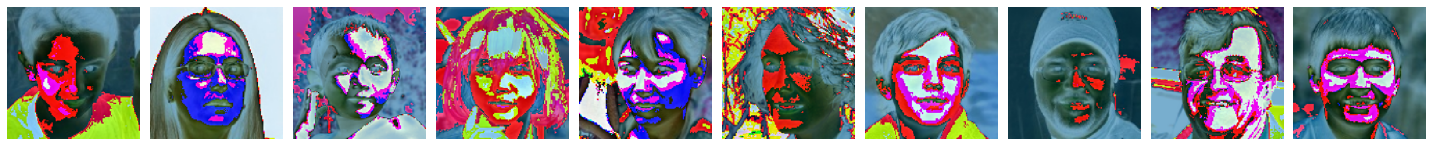

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [69]:
plotImages(imgs)
print(labels);

# Neural Net

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [70]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [72]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [75]:
n_samples_train//n_batch

10

In [76]:
model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

Epoch 1/10
10/10 - 8s - loss: 41.1366 - accuracy: 0.4700 - val_loss: 23.7463 - val_accuracy: 0.5000 - 8s/epoch - 759ms/step
Epoch 2/10
10/10 - 4s - loss: 24.6916 - accuracy: 0.6500 - val_loss: 46.8454 - val_accuracy: 0.5800 - 4s/epoch - 357ms/step
Epoch 3/10
10/10 - 4s - loss: 26.6605 - accuracy: 0.6500 - val_loss: 21.6100 - val_accuracy: 0.5600 - 4s/epoch - 361ms/step
Epoch 4/10
10/10 - 4s - loss: 15.5089 - accuracy: 0.7300 - val_loss: 18.8489 - val_accuracy: 0.6000 - 4s/epoch - 356ms/step
Epoch 5/10
10/10 - 4s - loss: 7.3827 - accuracy: 0.8100 - val_loss: 28.0103 - val_accuracy: 0.4600 - 4s/epoch - 364ms/step
Epoch 6/10
10/10 - 3s - loss: 7.8754 - accuracy: 0.8000 - val_loss: 12.0296 - val_accuracy: 0.6000 - 3s/epoch - 349ms/step
Epoch 7/10
10/10 - 4s - loss: 7.3174 - accuracy: 0.7800 - val_loss: 10.2467 - val_accuracy: 0.6400 - 4s/epoch - 360ms/step
Epoch 8/10
10/10 - 4s - loss: 2.8546 - accuracy: 0.8800 - val_loss: 22.7447 - val_accuracy: 0.5400 - 4s/epoch - 355ms/step
Epoch 9/10
1